# HDP spell-sound analyzer

developed by Kow Kuroda (kow.kuroda@gmail.com)

History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装
2024/10/28 Cython を使わない (skippy) n-gram 生成処理を高速化

In [1]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [2]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [3]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [4]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [5]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [6]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[0]
ngram_is_inclusive  = True
inclusion_degree    = None

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"

## term setting
term_is_skippy      = True
n_for_ngram         = 5
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")
## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
## check
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: spell
term_is_skippy: True
max_gap_size: 11
n_for_ngram: 5
accent_status: 
term_type: sp_skippy5gram


In [7]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]
## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [8]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units

# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate     = 0.02

In [9]:
## sampling
source_sampling           = True
source_sampling_rate      = 0.5
source_sampling_max_size  = 5000
second_sampling           = False
second_sampling_rate      = 0.7

In [10]:
## set target files
import glob
data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 '

In [11]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


,spell,sound
544612,sofrenaban,sofɾenaβan
330948,fascículos,faˈsθikulos
505736,remplazaréis,remplaθaˈɾeis
141198,convalidárnoslas,kombaliˈðaɾnozlas
557588,tamizaremos,tamiθaɾemos
141908,convulsionaren,kombulsjonaɾen
522153,rigideces,rixiðeθes
60971,apriscaste,apɾiskaste
264016,encureñado,eŋkuɾeɲaðo
318079,etimologizara,etimoloxiθaɾa


In [12]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                     spell               sound
6431          #abundabais#        #aβundaβais#
234828  #electrificábamos#  #elektɾifikaβamos#
184774     #desencargados#     #deseŋkaɾɣaðos#
370829     #independencia#     #independenθja#
234177          #egresión#          #eɣɾesjon#
...                    ...                 ...
522321         #rimbombad#         #rimbombað#
552738         #sujetando#         #suxetando#
455660     #pintoneáramos#     #pintoneaɾamos#
380663            #intimo#            #intimo#
222757     #difuminábamos#     #difuminaβamos#

[5000 rows x 2 columns]


In [13]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
6431,#abundabais#,#aβundaβais#,"[#, a, b, u, n, d, a, b, a, i, s, #]",12,0,0,"[#, a, β, u, n, d, a, β, a, i, s, #]",12
234828,#electrificábamos#,#elektɾifikaβamos#,"[#, e, l, e, c, t, r, i, f, i, c, á, b, a, m, ...",18,0,0,"[#, e, l, e, k, t, ɾ, i, f, i, k, a, β, a, m, ...",18
184774,#desencargados#,#deseŋkaɾɣaðos#,"[#, d, e, s, e, n, c, a, r, g, a, d, o, s, #]",15,0,0,"[#, d, e, s, e, ŋ, k, a, ɾ, ɣ, a, ð, o, s, #]",15
370829,#independencia#,#independenθja#,"[#, i, n, d, e, p, e, n, d, e, n, c, i, a, #]",15,0,0,"[#, i, n, d, e, p, e, n, d, e, n, θ, j, a, #]",15
234177,#egresión#,#eɣɾesjon#,"[#, e, g, r, e, s, i, ó, n, #]",10,0,0,"[#, e, ɣ, ɾ, e, s, j, o, n, #]",10
...,...,...,...,...,...,...,...,...
522321,#rimbombad#,#rimbombað#,"[#, r, i, m, b, o, m, b, a, d, #]",11,0,0,"[#, r, i, m, b, o, m, b, a, ð, #]",11
552738,#sujetando#,#suxetando#,"[#, s, u, j, e, t, a, n, d, o, #]",11,0,0,"[#, s, u, x, e, t, a, n, d, o, #]",11
455660,#pintoneáramos#,#pintoneaɾamos#,"[#, p, i, n, t, o, n, e, á, r, a, m, o, s, #]",15,0,0,"[#, p, i, n, t, o, n, e, a, ɾ, a, m, o, s, #]",15
380663,#intimo#,#intimo#,"[#, i, n, t, i, m, o, #]",8,0,0,"[#, i, n, t, i, m, o, #]",8


In [14]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_skippy5gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
234177,#egresión#,#eɣɾesjon#,"[#, e, g, r, e, s, i, ó, n, #]",10,0,0,"[#, e, ɣ, ɾ, e, s, j, o, n, #]",10
152981,#decrépito#,#dekɾepito#,"[#, d, e, c, r, é, p, i, t, o, #]",11,0,0,"[#, d, e, k, ɾ, e, p, i, t, o, #]",11
23379,#afilareis#,#afilaɾeis#,"[#, a, f, i, l, a, r, e, i, s, #]",11,0,0,"[#, a, f, i, l, a, ɾ, e, i, s, #]",11
232844,#duunviro#,#duumbiɾo#,"[#, d, u, u, n, v, i, r, o, #]",10,0,0,"[#, d, u, u, m, b, i, ɾ, o, #]",10
340714,#frenóloga#,#fɾenoloɣa#,"[#, f, r, e, n, ó, l, o, g, a, #]",11,0,0,"[#, f, ɾ, e, n, o, l, o, ɣ, a, #]",11
...,...,...,...,...,...,...,...,...
118854,#cicateros#,#θikateɾos#,"[#, c, i, c, a, t, e, r, o, s, #]",11,0,0,"[#, θ, i, k, a, t, e, ɾ, o, s, #]",11
145467,#cotorrees#,#kotorees#,"[#, c, o, t, o, r, r, e, e, s, #]",11,0,0,"[#, k, o, t, o, r, e, e, s, #]",10
522321,#rimbombad#,#rimbombað#,"[#, r, i, m, b, o, m, b, a, d, #]",11,0,0,"[#, r, i, m, b, o, m, b, a, ð, #]",11
552738,#sujetando#,#suxetando#,"[#, s, u, j, e, t, a, n, d, o, #]",11,0,0,"[#, s, u, x, e, t, a, n, d, o, #]",11


In [15]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

1835

In [16]:
## generic function for n-gram generation
def add_ngram_to_df (dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}skippy{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            #ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
            ## The following replaces the above
            ngrams = unigrams.apply(lambda x: [ seg_joint.join(y) for y in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check) ] )
            
        else:
            #ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
            ## The following replaces the above
            ngrams = unigrams.apply(lambda x: [ seg_joint.join(y) for y in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, check = check) ] )
    else:
        import gen_ngrams
        if skippy:
            #ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
            ngrams = unigrams.apply(lambda x: [ seg_joint.join(y) for y in gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check) ] )
        else:
            #ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
            ngrams = unigrams.apply(lambda x: [ seg_joint.join(y) for y in gen_ngrams.gen_ngrams(x, n = n_for_ngram, check = check) ] )
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [17]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
234177    [# e, e g, g r, r e, e s, s i, i ó, ó n, n #, ...
152981    [# d, d e, e c, c r, r é, é p, p i, i t, t o, ...
23379     [# a, a f, f i, i l, l a, a r, r e, e i, i s, ...
232844    [# d, d u, u u, u n, n v, v i, i r, r o, o #, ...
340714    [# f, f r, r e, e n, n ó, ó l, l o, o g, g a, ...
                                ...                        
118854    [# c, c i, i c, c a, a t, t e, e r, r o, o s, ...
145467    [# c, c o, o t, t o, o r, r r, r e, e e, e s, ...
522321    [# r, r i, i m, m b, b o, o m, m b, b a, a d, ...
552738    [# s, s u, u j, j e, e t, t a, a n, n d, d o, ...
380663    [# i, i n, n t, t i, i m, m o, o #, #, i, n, t...
Name: sp_2gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [18]:
## frequencies of 2grams
ngram_is_skippy = False
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[]

In [19]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


234177    [# e g, e g r, g r e, r e s, e s i, s i ó, i ó...
152981    [# d e, d e c, e c r, c r é, r é p, é p i, p i...
23379     [# a f, a f i, f i l, i l a, l a r, a r e, r e...
232844    [# d u, d u u, u u n, u n v, n v i, v i r, i r...
340714    [# f r, f r e, r e n, e n ó, n ó l, ó l o, l o...
                                ...                        
118854    [# c i, c i c, i c a, c a t, a t e, t e r, e r...
145467    [# c o, c o t, o t o, t o r, o r r, r r e, r e...
522321    [# r i, r i m, i m b, m b o, b o m, o m b, m b...
552738    [# s u, s u j, u j e, j e t, e t a, t a n, a n...
380663    [# i n, i n t, n t i, t i m, i m o, m o #, # i...
Name: sp_3gram, Length: 1835, dtype: object


In [20]:
## frequencies of 3grams
ngram_is_skippy = False
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('s #', 599),
 ('a r', 511),
 ('a s', 351),
 ('r e', 298),
 ('e s', 293),
 ('# a', 285),
 ('a #', 285),
 ('e n', 268),
 ('r a', 251),
 ('n #', 237),
 ('o #', 211),
 ('a n', 210),
 ('# e', 202),
 ('e #', 200),
 ('o s', 198),
 ('a d', 195),
 ('l a', 174),
 ('e r', 163),
 ('t e', 163),
 ('s e', 159),
 ('t a', 158),
 ('e a', 153),
 ('i s', 149),
 ('c a', 149),
 ('# r', 149),
 ('b a', 146),
 ('# c', 145),
 ('d e', 139),
 ('d o', 138),
 ('# p', 133)]

In [21]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
234177    [# e g r, e g r e, g r e s, r e s i, e s i ó, ...
152981    [# d e c, d e c r, e c r é, c r é p, r é p i, ...
23379     [# a f i, a f i l, f i l a, i l a r, l a r e, ...
232844    [# d u u, d u u n, u u n v, u n v i, n v i r, ...
340714    [# f r e, f r e n, r e n ó, e n ó l, n ó l o, ...
                                ...                        
118854    [# c i c, c i c a, i c a t, c a t e, a t e r, ...
145467    [# c o t, c o t o, o t o r, t o r r, o r r e, ...
522321    [# r i m, r i m b, i m b o, m b o m, b o m b, ...
552738    [# s u j, s u j e, u j e t, j e t a, e t a n, ...
380663    [# i n t, i n t i, n t i m, t i m o, i m o #, ...
Name: sp_4gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [22]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
234177    [# e g r e, e g r e s, g r e s i, r e s i ó, e...
152981    [# d e c r, d e c r é, e c r é p, c r é p i, r...
23379     [# a f i l, a f i l a, f i l a r, i l a r e, l...
232844    [# d u u n, d u u n v, u u n v i, u n v i r, n...
340714    [# f r e n, f r e n ó, r e n ó l, e n ó l o, n...
                                ...                        
118854    [# c i c a, c i c a t, i c a t e, c a t e r, a...
145467    [# c o t o, c o t o r, o t o r r, t o r r e, o...
522321    [# r i m b, r i m b o, i m b o m, m b o m b, b...
552738    [# s u j e, s u j e t, u j e t a, j e t a n, e...
380663    [# i n t i, i n t i m, n t i m o, t i m o #, #...
Name: sp_5gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [23]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy2gram
min_size: 1
supplement_var: sp_1gram


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


234177    [# e, # … g, # … r, # … e, # … s, # … i, # … ó...
152981    [# d, # … e, # … c, # … r, # … é, # … p, # … i...
23379     [# a, # … f, # … i, # … l, # … a, # … r, # … e...
232844    [# d, # … u, # … u, # … n, # … v, # … i, # … r...
340714    [# f, # … r, # … e, # … n, # … ó, # … l, # … o...
                                ...                        
118854    [# c, # … i, # … c, # … a, # … t, # … e, # … r...
145467    [# c, # … o, # … t, # … o, # … r, # … r, # … e...
522321    [# r, # … i, # … m, # … b, # … o, # … m, # … b...
552738    [# s, # … u, # … j, # … e, # … t, # … a, # … n...
380663    [# i, # … n, # … t, # … i, # … m, # … o, # … #...
Name: sp_skippy2gram, Length: 1835, dtype: object


In [24]:
## frequencies of skippy 2grams
ngram_is_skippy = True
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[]

In [25]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy3gram
min_size: 1
supplement_var: sp_skippy2gram
234177    [# e g, # e … r, # e … e, # e … s, # e … i, # ...
152981    [# d e, # d … c, # d … r, # d … é, # d … p, # ...
23379     [# a f, # a … i, # a … l, # a … a, # a … r, # ...
232844    [# d u, # d … u, # d … n, # d … v, # d … i, # ...
340714    [# f r, # f … e, # f … n, # f … ó, # f … l, # ...
                                ...                        
118854    [# c i, # c … c, # c … a, # c … t, # c … e, # ...
145467    [# c o, # c … t, # c … o, # c … r, # c … r, # ...
522321    [# r i, # r … m, # r … b, # r … o, # r … m, # ...
552738    [# s u, # s … j, # s … e, # s … t, # s … a, # ...
380663    [# i n, # i … t, # i … i, # i … m, # i … o, # ...
Name: sp_skippy3gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [26]:
## frequencies of skippy 3grams
ngram_is_skippy = True
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('s #', 599),
 ('a r', 511),
 ('a s', 351),
 ('r e', 298),
 ('e s', 293),
 ('# a', 285),
 ('a #', 285),
 ('e n', 268),
 ('r a', 251),
 ('n #', 237),
 ('o #', 211),
 ('a n', 210),
 ('# e', 202),
 ('e #', 200),
 ('o s', 198),
 ('a d', 195),
 ('l a', 174),
 ('e r', 163),
 ('t e', 163),
 ('s e', 159),
 ('t a', 158),
 ('e a', 153),
 ('i s', 149),
 ('c a', 149),
 ('# r', 149),
 ('b a', 146),
 ('# c', 145),
 ('d e', 139),
 ('d o', 138),
 ('# p', 133)]

In [27]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy4gram
min_size: 1
supplement_var: sp_skippy3gram
234177    [# e g r, # e g … e, # e g … s, # e g … i, # e...
152981    [# d e c, # d e … r, # d e … é, # d e … p, # d...
23379     [# a f i, # a f … l, # a f … a, # a f … r, # a...
232844    [# d u u, # d u … n, # d u … v, # d u … i, # d...
340714    [# f r e, # f r … n, # f r … ó, # f r … l, # f...
                                ...                        
118854    [# c i c, # c i … a, # c i … t, # c i … e, # c...
145467    [# c o t, # c o … o, # c o … r, # c o … r, # c...
522321    [# r i m, # r i … b, # r i … o, # r i … m, # r...
552738    [# s u j, # s u … e, # s u … t, # s u … a, # s...
380663    [# i n t, # i n … i, # i n … m, # i n … o, # i...
Name: sp_skippy4gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [28]:
## frequencies of skippy 4grams
ngram_is_skippy = True
n_now = 4
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('# … a', 2044),
 ('a … #', 2044),
 ('# … #', 1835),
 ('e … #', 1421),
 ('# … e', 1419),
 ('r … #', 1279),
 ('# … r', 1187),
 ('a … a', 1094),
 ('# … s', 1093),
 ('# … o', 941),
 ('i … #', 867),
 ('# … n', 819),
 ('# … i', 815),
 ('e … a', 779),
 ('o … #', 766),
 ('a … e', 678),
 ('a … s', 672),
 ('r … a', 619),
 ('n … #', 606),
 ('l … #', 596),
 ('s … #', 595),
 ('t … #', 585),
 ('c … #', 549),
 ('# … l', 531),
 ('r … s', 508),
 ('o … a', 499),
 ('d … #', 491),
 ('# … t', 481),
 ('e … s', 479),
 ('e … e', 463)]

In [29]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy5gram
min_size: 1
supplement_var: sp_skippy4gram
234177    [# e g r e, # e g r … s, # e g r … i, # e g r ...
152981    [# d e c r, # d e c … é, # d e c … p, # d e c ...
23379     [# a f i l, # a f i … a, # a f i … r, # a f i ...
232844    [# d u u n, # d u u … v, # d u u … i, # d u u ...
340714    [# f r e n, # f r e … ó, # f r e … l, # f r e ...
                                ...                        
118854    [# c i c a, # c i c … t, # c i c … e, # c i c ...
145467    [# c o t o, # c o t … r, # c o t … r, # c o t ...
522321    [# r i m b, # r i m … o, # r i m … m, # r i m ...
552738    [# s u j e, # s u j … t, # s u j … a, # s u j ...
380663    [# i n t i, # i n t … m, # i n t … o, # i n t ...
Name: sp_skippy5gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [30]:
## frequencies of skippy 5grams
ngram_is_skippy = True
n_now = 5
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('a s #', 192),
 ('e s #', 142),
 ('o s #', 141),
 ('i s #', 101),
 ('# r e', 101),
 ('a n #', 100),
 ('# e n', 98),
 ('# d e', 91),
 ('a r a', 87),
 ('a b a', 84),
 ('a s e', 81),
 ('a r e', 80),
 ('e n #', 74),
 ('a d o', 74),
 ('d o #', 74),
 ('d e s', 68),
 ('a r á', 66),
 ('e a r', 63),
 ('t e #', 57),
 ('r í a', 56),
 ('r a s', 55),
 ('r a #', 51),
 ('a d a', 50),
 ('r e s', 49),
 ('a d #', 48),
 ('d a #', 47),
 ('m o s', 47),
 ('a r í', 46),
 ('a r #', 44),
 ('r e #', 43)]

In [31]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram
234177,#egresión#,"[#, e, g, r, e, s, i, ó, n, #]","[# e, e g, g r, r e, e s, s i, i ó, ó n, n #, ...","[# e g, e g r, g r e, r e s, e s i, s i ó, i ó...","[# e g r, e g r e, g r e s, r e s i, e s i ó, ...","[# e g r e, e g r e s, g r e s i, r e s i ó, e...","[# e, # … g, # … r, # … e, # … s, # … i, # … ó...","[# e g, # e … r, # e … e, # e … s, # e … i, # ...","[# e g r, # e g … e, # e g … s, # e g … i, # e...","[# e g r e, # e g r … s, # e g r … i, # e g r ..."
152981,#decrépito#,"[#, d, e, c, r, é, p, i, t, o, #]","[# d, d e, e c, c r, r é, é p, p i, i t, t o, ...","[# d e, d e c, e c r, c r é, r é p, é p i, p i...","[# d e c, d e c r, e c r é, c r é p, r é p i, ...","[# d e c r, d e c r é, e c r é p, c r é p i, r...","[# d, # … e, # … c, # … r, # … é, # … p, # … i...","[# d e, # d … c, # d … r, # d … é, # d … p, # ...","[# d e c, # d e … r, # d e … é, # d e … p, # d...","[# d e c r, # d e c … é, # d e c … p, # d e c ..."
23379,#afilareis#,"[#, a, f, i, l, a, r, e, i, s, #]","[# a, a f, f i, i l, l a, a r, r e, e i, i s, ...","[# a f, a f i, f i l, i l a, l a r, a r e, r e...","[# a f i, a f i l, f i l a, i l a r, l a r e, ...","[# a f i l, a f i l a, f i l a r, i l a r e, l...","[# a, # … f, # … i, # … l, # … a, # … r, # … e...","[# a f, # a … i, # a … l, # a … a, # a … r, # ...","[# a f i, # a f … l, # a f … a, # a f … r, # a...","[# a f i l, # a f i … a, # a f i … r, # a f i ..."
232844,#duunviro#,"[#, d, u, u, n, v, i, r, o, #]","[# d, d u, u u, u n, n v, v i, i r, r o, o #, ...","[# d u, d u u, u u n, u n v, n v i, v i r, i r...","[# d u u, d u u n, u u n v, u n v i, n v i r, ...","[# d u u n, d u u n v, u u n v i, u n v i r, n...","[# d, # … u, # … u, # … n, # … v, # … i, # … r...","[# d u, # d … u, # d … n, # d … v, # d … i, # ...","[# d u u, # d u … n, # d u … v, # d u … i, # d...","[# d u u n, # d u u … v, # d u u … i, # d u u ..."
340714,#frenóloga#,"[#, f, r, e, n, ó, l, o, g, a, #]","[# f, f r, r e, e n, n ó, ó l, l o, o g, g a, ...","[# f r, f r e, r e n, e n ó, n ó l, ó l o, l o...","[# f r e, f r e n, r e n ó, e n ó l, n ó l o, ...","[# f r e n, f r e n ó, r e n ó l, e n ó l o, n...","[# f, # … r, # … e, # … n, # … ó, # … l, # … o...","[# f r, # f … e, # f … n, # f … ó, # f … l, # ...","[# f r e, # f r … n, # f r … ó, # f r … l, # f...","[# f r e n, # f r e … ó, # f r e … l, # f r e ..."
...,...,...,...,...,...,...,...,...,...,...
118854,#cicateros#,"[#, c, i, c, a, t, e, r, o, s, #]","[# c, c i, i c, c a, a t, t e, e r, r o, o s, ...","[# c i, c i c, i c a, c a t, a t e, t e r, e r...","[# c i c, c i c a, i c a t, c a t e, a t e r, ...","[# c i c a, c i c a t, i c a t e, c a t e r, a...","[# c, # … i, # … c, # … a, # … t, # … e, # … r...","[# c i, # c … c, # c … a, # c … t, # c … e, # ...","[# c i c, # c i … a, # c i … t, # c i … e, # c...","[# c i c a, # c i c … t, # c i c … e, # c i c ..."
145467,#cotorrees#,"[#, c, o, t, o, r, r, e, e, s, #]","[# c, c o, o t, t o, o r, r r, r e, e e, e s, ...","[# c o, c o t, o t o, t o r, o r r, r r e, r e...","[# c o t, c o t o, o t o r, t o r r, o r r e, ...","[# c o t o, c o t o r, o t o r r, t o r r e, o...","[# c, # … o, # … t, # … o, # … r, # … r, # … e...","[# c o, # c … t, # c … o, # c … r, # c … r, # ...","[# c o t, # c o … o, # c o … r, # c o … r, # c...","[# c o t o, # c o t … r, # c o t … r, # c o t ..."
522321,#rimbombad#,"[#, r, i, m, b, o, m, b, a, d, #]","[# r, r i, i m, m b, b o, o m, m b, b a, a d, ...","[# r i, r i m, i m b, m b o, b o m, o m b, m b...","[# r i m, r i m b, i m b o, m b o m, b o m b, ...","[# r i m b, r i m b o, i m b o m, m b o m b, b...","[# r, # … i, # … m, # … b, # … o, # … m, # … b...","[# r i, # r … m, # r … b, # r … o, # r … m, # ...","[# r i m, # r i … b, # r i … o, # r i … m, # r...","[# r i m b, # r i m … o, # r i m … m, # r i m ..."
552738,#sujetando#,"[#, s, u, j, e, t, a, n, d, o, #]","[# s, s u, u j, j e, e t, t a

# Sound

In [32]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
234177    [# e, e ɣ, ɣ ɾ, ɾ e, e s, s j, j o, o n, n #, ...
152981    [# d, d e, e k, k ɾ, ɾ e, e p, p i, i t, t o, ...
23379     [# a, a f, f i, i l, l a, a ɾ, ɾ e, e i, i s, ...
232844    [# d, d u, u u, u m, m b, b i, i ɾ, ɾ o, o #, ...
340714    [# f, f ɾ, ɾ e, e n, n o, o l, l o, o ɣ, ɣ a, ...
                                ...                        
118854    [# θ, θ i, i k, k a, a t, t e, e ɾ, ɾ o, o s, ...
145467    [# k, k o, o t, t o, o r, r e, e e, e s, s #, ...
522321    [# r, r i, i m, m b, b o, o m, m b, b a, a ð, ...
552738    [# s, s u, u x, x e, e t, t a, a n, n d, d o, ...
380663    [# i, i n, n t, t i, i m, m o, o #, #, i, n, t...
Name: sn_2gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [33]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
234177    [# e ɣ, e ɣ ɾ, ɣ ɾ e, ɾ e s, e s j, s j o, j o...
152981    [# d e, d e k, e k ɾ, k ɾ e, ɾ e p, e p i, p i...
23379     [# a f, a f i, f i l, i l a, l a ɾ, a ɾ e, ɾ e...
232844    [# d u, d u u, u u m, u m b, m b i, b i ɾ, i ɾ...
340714    [# f ɾ, f ɾ e, ɾ e n, e n o, n o l, o l o, l o...
                                ...                        
118854    [# θ i, θ i k, i k a, k a t, a t e, t e ɾ, e ɾ...
145467    [# k o, k o t, o t o, t o r, o r e, r e e, e e...
522321    [# r i, r i m, i m b, m b o, b o m, o m b, m b...
552738    [# s u, s u x, u x e, x e t, e t a, t a n, a n...
380663    [# i n, i n t, n t i, t i m, i m o, m o #, # i...
Name: sn_3gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [34]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
234177    [# e ɣ ɾ, e ɣ ɾ e, ɣ ɾ e s, ɾ e s j, e s j o, ...
152981    [# d e k, d e k ɾ, e k ɾ e, k ɾ e p, ɾ e p i, ...
23379     [# a f i, a f i l, f i l a, i l a ɾ, l a ɾ e, ...
232844    [# d u u, d u u m, u u m b, u m b i, m b i ɾ, ...
340714    [# f ɾ e, f ɾ e n, ɾ e n o, e n o l, n o l o, ...
                                ...                        
118854    [# θ i k, θ i k a, i k a t, k a t e, a t e ɾ, ...
145467    [# k o t, k o t o, o t o r, t o r e, o r e e, ...
522321    [# r i m, r i m b, i m b o, m b o m, b o m b, ...
552738    [# s u x, s u x e, u x e t, x e t a, e t a n, ...
380663    [# i n t, i n t i, n t i m, t i m o, i m o #, ...
Name: sn_4gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [35]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
234177    [# e ɣ ɾ e, e ɣ ɾ e s, ɣ ɾ e s j, ɾ e s j o, e...
152981    [# d e k ɾ, d e k ɾ e, e k ɾ e p, k ɾ e p i, ɾ...
23379     [# a f i l, a f i l a, f i l a ɾ, i l a ɾ e, l...
232844    [# d u u m, d u u m b, u u m b i, u m b i ɾ, m...
340714    [# f ɾ e n, f ɾ e n o, ɾ e n o l, e n o l o, n...
                                ...                        
118854    [# θ i k a, θ i k a t, i k a t e, k a t e ɾ, a...
145467    [# k o t o, k o t o r, o t o r e, t o r e e, o...
522321    [# r i m b, r i m b o, i m b o m, m b o m b, b...
552738    [# s u x e, s u x e t, u x e t a, x e t a n, e...
380663    [# i n t i, i n t i m, n t i m o, t i m o #, #...
Name: sn_5gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [36]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy2gram
min_size: 1
supplement_var: sn_1gram
234177    [# e, # … ɣ, # … ɾ, # … e, # … s, # … j, # … o...
152981    [# d, # … e, # … k, # … ɾ, # … e, # … p, # … i...
23379     [# a, # … f, # … i, # … l, # … a, # … ɾ, # … e...
232844    [# d, # … u, # … u, # … m, # … b, # … i, # … ɾ...
340714    [# f, # … ɾ, # … e, # … n, # … o, # … l, # … o...
                                ...                        
118854    [# θ, # … i, # … k, # … a, # … t, # … e, # … ɾ...
145467    [# k, # … o, # … t, # … o, # … r, # … e, # … e...
522321    [# r, # … i, # … m, # … b, # … o, # … m, # … b...
552738    [# s, # … u, # … x, # … e, # … t, # … a, # … n...
380663    [# i, # … n, # … t, # … i, # … m, # … o, # … #...
Name: sn_skippy2gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [37]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy3gram
min_size: 1
supplement_var: sn_skippy2gram
234177    [# e ɣ, # e … ɾ, # e … e, # e … s, # e … j, # ...
152981    [# d e, # d … k, # d … ɾ, # d … e, # d … p, # ...
23379     [# a f, # a … i, # a … l, # a … a, # a … ɾ, # ...
232844    [# d u, # d … u, # d … m, # d … b, # d … i, # ...
340714    [# f ɾ, # f … e, # f … n, # f … o, # f … l, # ...
                                ...                        
118854    [# θ i, # θ … k, # θ … a, # θ … t, # θ … e, # ...
145467    [# k o, # k … t, # k … o, # k … r, # k … e, # ...
522321    [# r i, # r … m, # r … b, # r … o, # r … m, # ...
552738    [# s u, # s … x, # s … e, # s … t, # s … a, # ...
380663    [# i n, # i … t, # i … i, # i … m, # i … o, # ...
Name: sn_skippy3gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [38]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy4gram
min_size: 1
supplement_var: sn_skippy3gram
234177    [# e ɣ ɾ, # e ɣ … e, # e ɣ … s, # e ɣ … j, # e...
152981    [# d e k, # d e … ɾ, # d e … e, # d e … p, # d...
23379     [# a f i, # a f … l, # a f … a, # a f … ɾ, # a...
232844    [# d u u, # d u … m, # d u … b, # d u … i, # d...
340714    [# f ɾ e, # f ɾ … n, # f ɾ … o, # f ɾ … l, # f...
                                ...                        
118854    [# θ i k, # θ i … a, # θ i … t, # θ i … e, # θ...
145467    [# k o t, # k o … o, # k o … r, # k o … e, # k...
522321    [# r i m, # r i … b, # r i … o, # r i … m, # r...
552738    [# s u x, # s u … e, # s u … t, # s u … a, # s...
380663    [# i n t, # i n … i, # i n … m, # i n … o, # i...
Name: sn_skippy4gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [39]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy5gram
min_size: 1
supplement_var: sn_skippy4gram
234177    [# e ɣ ɾ e, # e ɣ ɾ … s, # e ɣ ɾ … j, # e ɣ ɾ ...
152981    [# d e k ɾ, # d e k … e, # d e k … p, # d e k ...
23379     [# a f i l, # a f i … a, # a f i … ɾ, # a f i ...
232844    [# d u u m, # d u u … b, # d u u … i, # d u u ...
340714    [# f ɾ e n, # f ɾ e … o, # f ɾ e … l, # f ɾ e ...
                                ...                        
118854    [# θ i k a, # θ i k … t, # θ i k … e, # θ i k ...
145467    [# k o t o, # k o t … r, # k o t … e, # k o t ...
522321    [# r i m b, # r i m … o, # r i m … m, # r i m ...
552738    [# s u x e, # s u x … t, # s u x … a, # s u x ...
380663    [# i n t i, # i n t … m, # i n t … o, # i n t ...
Name: sn_skippy5gram, Length: 1835, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/2495020733.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [40]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram,sn_5gram,sn_skippy5gram
234177,#egresión#,#eɣɾesjon#,"[#, e, g, r, e, s, i, ó, n, #]","[# e, e g, g r, r e, e s, s i, i ó, ó n, n #, ...","[# e g, e g r, g r e, r e s, e s i, s i ó, i ó...","[# e g r, e g r e, g r e s, r e s i, e s i ó, ...","[# e g r e, e g r e s, g r e s i, r e s i ó, e...","[# e, # … g, # … r, # … e, # … s, # … i, # … ó...","[# e g, # e … r, # e … e, # e … s, # e … i, # ...","[# e g r, # e g … e, # e g … s, # e g … i, # e...","[# e g r e, # e g r … s, # e g r … i, # e g r ...","[# e ɣ ɾ e, e ɣ ɾ e s, ɣ ɾ e s j, ɾ e s j o, e...","[# e ɣ ɾ e, # e ɣ ɾ … s, # e ɣ ɾ … j, # e ɣ ɾ ..."
152981,#decrépito#,#dekɾepito#,"[#, d, e, c, r, é, p, i, t, o, #]","[# d, d e, e c, c r, r é, é p, p i, i t, t o, ...","[# d e, d e c, e c r, c r é, r é p, é p i, p i...","[# d e c, d e c r, e c r é, c r é p, r é p i, ...","[# d e c r, d e c r é, e c r é p, c r é p i, r...","[# d, # … e, # … c, # … r, # … é, # … p, # … i...","[# d e, # d … c, # d … r, # d … é, # d … p, # ...","[# d e c, # d e … r, # d e … é, # d e … p, # d...","[# d e c r, # d e c … é, # d e c … p, # d e c ...","[# d e k ɾ, d e k ɾ e, e k ɾ e p, k ɾ e p i, ɾ...","[# d e k ɾ, # d e k … e, # d e k … p, # d e k ..."
23379,#afilareis#,#afilaɾeis#,"[#, a, f, i, l, a, r, e, i, s, #]","[# a, a f, f i, i l, l a, a r, r e, e i, i s, ...","[# a f, a f i, f i l, i l a, l a r, a r e, r e...","[# a f i, a f i l, f i l a, i l a r, l a r e, ...","[# a f i l, a f i l a, f i l a r, i l a r e, l...","[# a, # … f, # … i, # … l, # … a, # … r, # … e...","[# a f, # a … i, # a … l, # a … a, # a … r, # ...","[# a f i, # a f … l, # a f … a, # a f … r, # a...","[# a f i l, # a f i … a, # a f i … r, # a f i ...","[# a f i l, a f i l a, f i l a ɾ, i l a ɾ e, l...","[# a f i l, # a f i … a, # a f i … ɾ, # a f i ..."
232844,#duunviro#,#duumbiɾo#,"[#, d, u, u, n, v, i, r, o, #]","[# d, d u, u u, u n, n v, v i, i r, r o, o #, ...","[# d u, d u u, u u n, u n v, n v i, v i r, i r...","[# d u u, d u u n, u u n v, u n v i, n v i r, ...","[# d u u n, d u u n v, u u n v i, u n v i r, n...","[# d, # … u, # … u, # … n, # … v, # … i, # … r...","[# d u, # d … u, # d … n, # d … v, # d … i, # ...","[# d u u, # d u … n, # d u … v, # d u … i, # d...","[# d u u n, # d u u … v, # d u u … i, # d u u ...","[# d u u m, d u u m b, u u m b i, u m b i ɾ, m...","[# d u u m, # d u u … b, # d u u … i, # d u u ..."
340714,#frenóloga#,#fɾenoloɣa#,"[#, f, r, e, n, ó, l, o, g, a, #]","[# f, f r, r e, e n, n ó, ó l, l o, o g, g a, ...","[# f r, f r e, r e n, e n ó, n ó l, ó l o, l o...","[# f r e, f r e n, r e n ó, e n ó l, n ó l o, ...","[# f r e n, f r e n ó, r e n ó l, e n ó l o, n...","[# f, # … r, # … e, # … n, # … ó, # … l, # … o...","[# f r, # f … e, # f … n, # f … ó, # f … l, # ...","[# f r e, # f r … n, # f r … ó, # f r … l, # f...","[# f r e n, # f r e … ó, # f r e … l, # f r e ...","[# f ɾ e n, f ɾ e n o, ɾ e n o l, e n o l o, n...","[# f ɾ e n, # f ɾ e … o, # f ɾ e … l, # f ɾ e ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118854,#cicateros#,#θikateɾos#,"[#, c, i, c, a, t, e, r, o, s, #]","[# c, c i, i c, c a, a t, t e, e r, r o, o s, ...","[# c i, c i c, i c a, c a t, a t e, t e r, e r...","[# c i c, c i c a, i c a t, c a t e, a t e r, ...","[# c i c a, c i c a t, i c a t e, c a t e r, a...","[# c, # … i, # … c, # … a, # … t, # … e, # … r...","[# c i, # c … c, # c … a, # c … t, # c … e, # ...","[# c i c, # c i … a, # c i … t, # c i … e, # c...","[# c i c a, # c i c … t, # c i c … e, # c i c ...","[# θ i k a, θ i k a t, i k a t e, k a t e ɾ, a...","[# θ i k a, # θ i k … t, # θ i k … e, # θ i k ..."
145467,#cotorrees#,#kotorees#,"[#, c, o, t, o, r, r, e, e, s, #]","[# c, c o, o t, t o, o r, r r, r e, e e, e s, ...","[# c o, c o t, o t o, t o r, o r r, r r e, r e...","[# c o t, c o t o, o t o r, t o r r, o r r e, ...","[# c o t o, c o t o r, o t o r r, t o r r e, o...","[# c, # … o, # …

# Analysis

In [41]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [42]:
#import HDP_utils

In [43]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_64694/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(1339, '#enrodo#'),
 (687, '#deslicéis#'),
 (262, '#imputaste#'),
 (1814, '#viperinas#'),
 (183, '#enrices#'),
 (1462, '#estibaran#'),
 (312, '#soasares#'),
 (567, '#marearte#'),
 (748, '#queules#'),
 (920, '#solazase#')]

In [44]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['# e n t a',
  '# e n t … l',
  '# e n t … l',
  '# e n t … é',
  '# e n t … i',
  '# e n t … s',
  '# e n t … #',
  '# e n … a l',
  '# e n … a … l',
  '# e n … a … é',
  '# e n … a … i',
  '# e n … a … s',
  '# e n … a … #',
  '# e n … l l',
  '# e n … l … é',
  '# e n … l … i',
  '# e n … l … s',
  '# e n … l … #',
  '# e n … l é',
  '# e n … l … i',
  '# e n … l … s',
  '# e n … l … #',
  '# e n … é i',
  '# e n … é … s',
  '# e n … é … #',
  '# e n … i s',
  '# e n … i … #',
  '# e n … s #',
  '# e … t a l',
  '# e … t a … l',
  '# e … t a … é',
  '# e … t a … i',
  '# e … t a … s',
  '# e … t a … #',
  '# e … t … l l',
  '# e … t … l … é',
  '# e … t … l … i',
  '# e … t … l … s',
  '# e … t … l … #',
  '# e … t … l é',
  '# e … t … l … i',
  '# e … t … l … s',
  '# e … t … l … #',
  '# e … t … é i',
  '# e … t … é … s',
  '# e … t … é … #',
  '# e … t … i s',
  '# e … t … i … #',
  '# e … t … s #',
  '# e … a l l',
  '# e … a l … é',
  '# e … a l … i',
  '# e … a l … s',
  '# 

In [45]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<461231 unique tokens: ['#', '# e', '# e g', '# e g r', '# e g r e']...>
term filtering applied
Dictionary<100000 unique tokens: ['# e g', '# e g … #', '# e g … e', '# e g … n', '# e g … s']...>


In [46]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [47]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [48]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [49]:
## import helper functions
import numpy as np
import HDP_helper
reload_module = True
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

In [50]:
## topic investigation
target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * a … á + 0.0 * e s … a + 0.0 * # d … s + 0.0 * # … a … á + 0.0 * e s … a … # + 0.0 * # d … a + 0.0 * # … e s … a + 0.0 * # … e s … a … # + 0.0 * # … i … a s + 0.0 * # d … a … # + 0.0 * d e … a + 0.0 * # d e … a + 0.0 * a … é + 0.0 * a … á … # + 0.0 * d e … a … # + 0.0 * # d … s … # + 0.0 * # d e … a … # + 0.0 * i … a s + 0.0 * # a … a … s + 0.0 * # d e
nonzero count:  482
	0.9990: #visearías#
	0.9989: #aviejaras#
	0.9989: #aforaseis#
	0.9989: #aviejarás#
	0.9988: #denotasen#
	0.9988: #aporrarás#
	0.9988: #brujeabas#
	0.9987: #deslamado#
	0.9987: #aparrando#
	0.9987: #atracarás#
	0.9987: #deprecará#
	0.9987: #rumbeabas#
	0.9987: #desgarras#
	0.9987: #tamborear#
	0.9987: #rumbeares#
topic_id 1: 0.0 * n … o # + 0.0 * # … n … o # + 0.0 * # e … n + 0.0 * e … e n + 0.0 * m … n … # + 0.0 * # … c … e … # + 0.0 * c … n … # + 0.0 * c … t … # + 0.0 * c … t + 0.0 * c … t e + 0.0 * # … a … d … # + 0.0 * # … e … c … # + 0.0 * c … d + 0.0 * # … i … o # + 0.0 * i … o # + 0.0 * e … a …

In [51]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

11285 rows remain after density filtering, discarding 88715 rows
724 rows remain after size filtering, discarding 10561 rows
290 rows remain after size filtering, discarding 434 rows


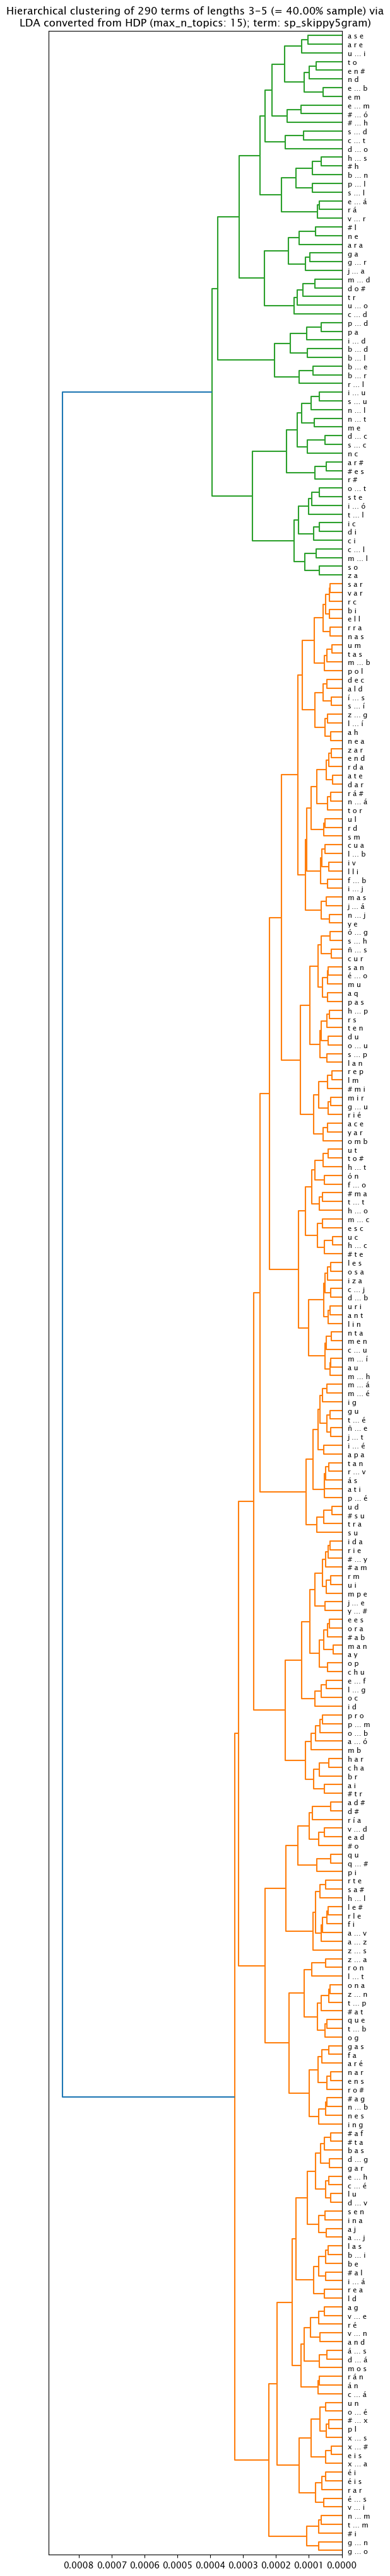

In [63]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp15, diction, term_type = term_type, n_topics= 15, lowest_density = 0.0002, max_length = n_for_ngram, min_length = 3, sampling_rate = 0.4, gap_mark = gap_mark, use_CJK = False, check = False)

In [53]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [54]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [55]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [56]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * # … a … d … # + 0.0 * a … á + 0.0 * e s … a + 0.0 * a … e … s + 0.0 * e s … a … # + 0.0 * # … a … á + 0.0 * # c … a … # + 0.0 * d e … a + 0.0 * # … e … n … # + 0.0 * e … a s # + 0.0 * # d … s + 0.0 * a … e … s # + 0.0 * # … i … o … # + 0.0 * r e … s + 0.0 * # … e s … a + 0.0 * # … e s … a … # + 0.0 * a … e … a + 0.0 * # … e … a s # + 0.0 * # c … r … # + 0.0 * # c … r
nonzero count: 430
	0.9990: #aviejaras#
	0.9990: #denotasen#
	0.9989: #prensarás#
	0.9989: #canteadas#
	0.9989: #coronaras#
	0.9988: #vitoreará#
	0.9988: #chuleadas#
	0.9988: #pitorrear#
	0.9988: #deprecará#
	0.9988: #perneases#
	0.9988: #rumbeares#
	0.9988: #rescindes#
	0.9988: #despojara#
	0.9988: #chuleados#
	0.9988: #desasente#
topic_id 1: 0.0 * i … o # + 0.0 * # … i … o # + 0.0 * r … o # + 0.0 * d … o + 0.0 * # … r … o # + 0.0 * # d … o + 0.0 * # d e … # + 0.0 * d e … o + 0.0 * # d e + 0.0 * # d e … o + 0.0 * # … f … # + 0.0 * f … a + 0.0 * # … f + 0.0 * # … n … i + 0.0 * # … n … i … # + 0.0 * i … e 

7798 rows remain after density filtering, discarding 92202 rows
623 rows remain after size filtering, discarding 7175 rows
187 rows remain after size filtering, discarding 436 rows


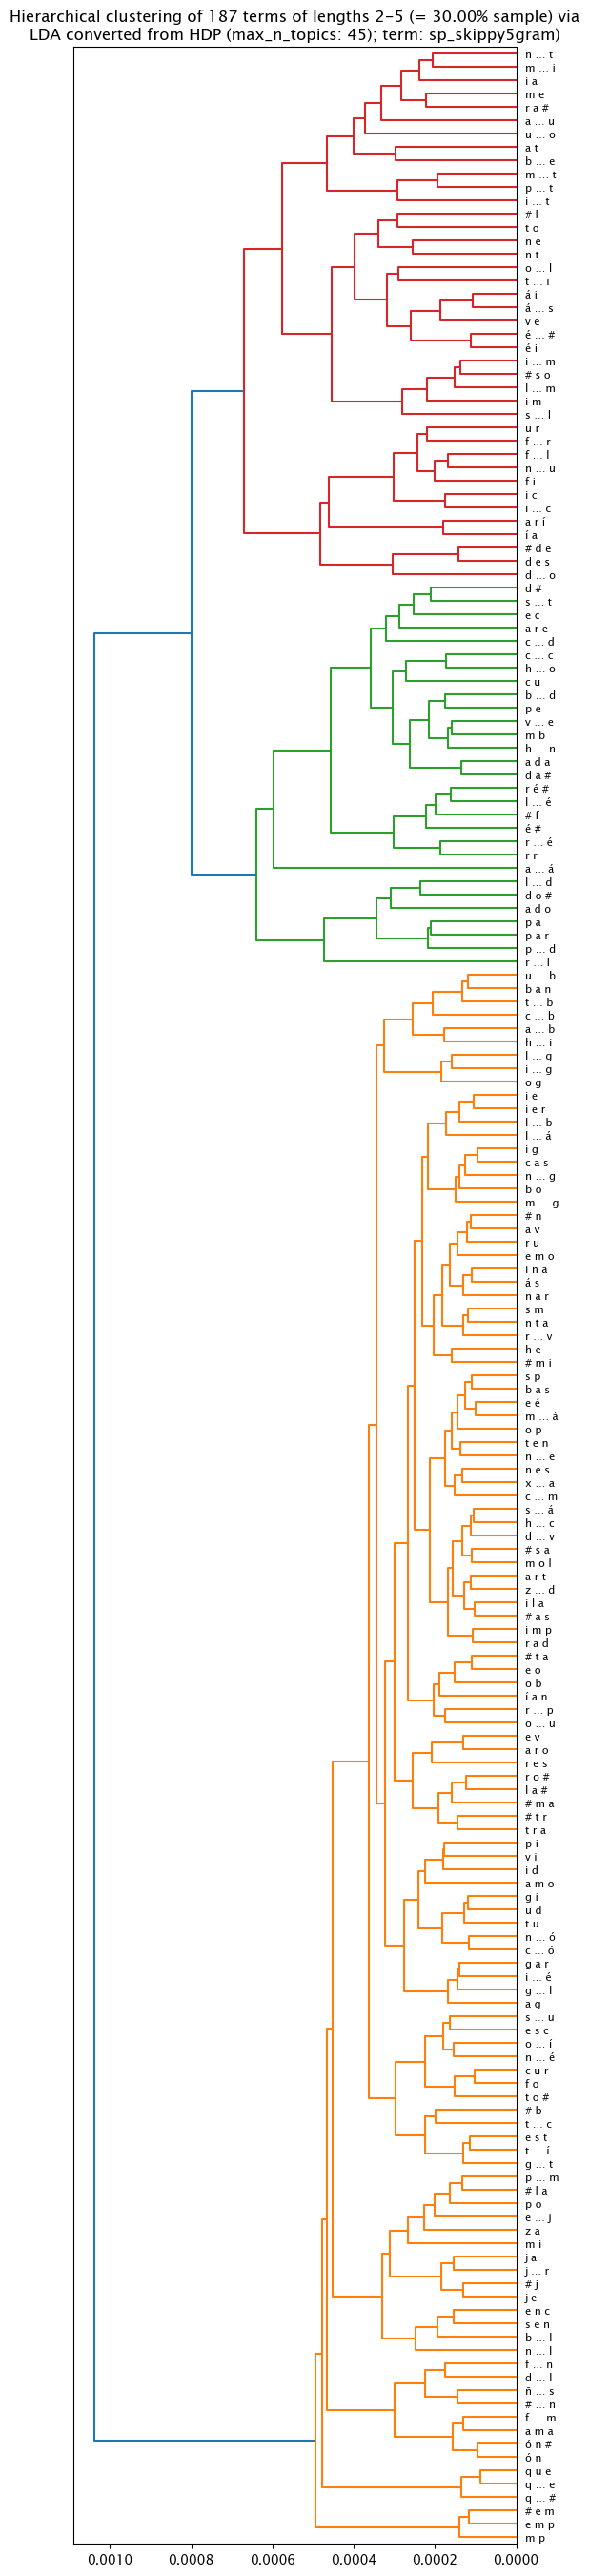

In [66]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp45, diction, term_type = term_type, n_topics = 45, lowest_density = 0.0006, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.3, check = False)

In [58]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [59]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [60]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [61]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * e s … a + 0.0 * e s … a … # + 0.0 * # … e … s … # + 0.0 * a … e n + 0.0 * # … i … o … # + 0.0 * n … a s + 0.0 * # … e s … a + 0.0 * # d … s + 0.0 * # c … a … # + 0.0 * # … e s … a … # + 0.0 * # … a … e n + 0.0 * # c … r … # + 0.0 * # c … r + 0.0 * # … m … n + 0.0 * c … t + 0.0 * # c … e + 0.0 * e … e n + 0.0 * c … t … # + 0.0 * # d … s … # + 0.0 * # … m … e
nonzero count:  337
	0.9989: #denotasen#
	0.9988: #canteadas#
	0.9988: #coronaras#
	0.9988: #rehogasen#
	0.9987: #desasente#
	0.9987: #engastara#
	0.9987: #irrogasen#
	0.9987: #remesaron#
	0.9987: #desovasen#
	0.9987: #cicateros#
	0.9986: #entalonen#
	0.9986: #harnearen#
	0.9986: #estamento#
	0.9985: #cotorrees#
	0.9985: #pivotasen#
topic_id 1: 0.0 * a … á + 0.0 * r … b … # + 0.0 * r … b + 0.0 * a … i s + 0.0 * a … i s # + 0.0 * # … a … á + 0.0 * b … r + 0.0 * b … r … # + 0.0 * # a … a … s + 0.0 * # … b … s + 0.0 * a … e s + 0.0 * # … b a … # + 0.0 * # r … b + 0.0 * a … e s # + 0.0 * # r … b … # + 0.0 * r … a … s #

6821 rows remain after density filtering, discarding 93179 rows
594 rows remain after size filtering, discarding 6227 rows
178 rows remain after size filtering, discarding 416 rows


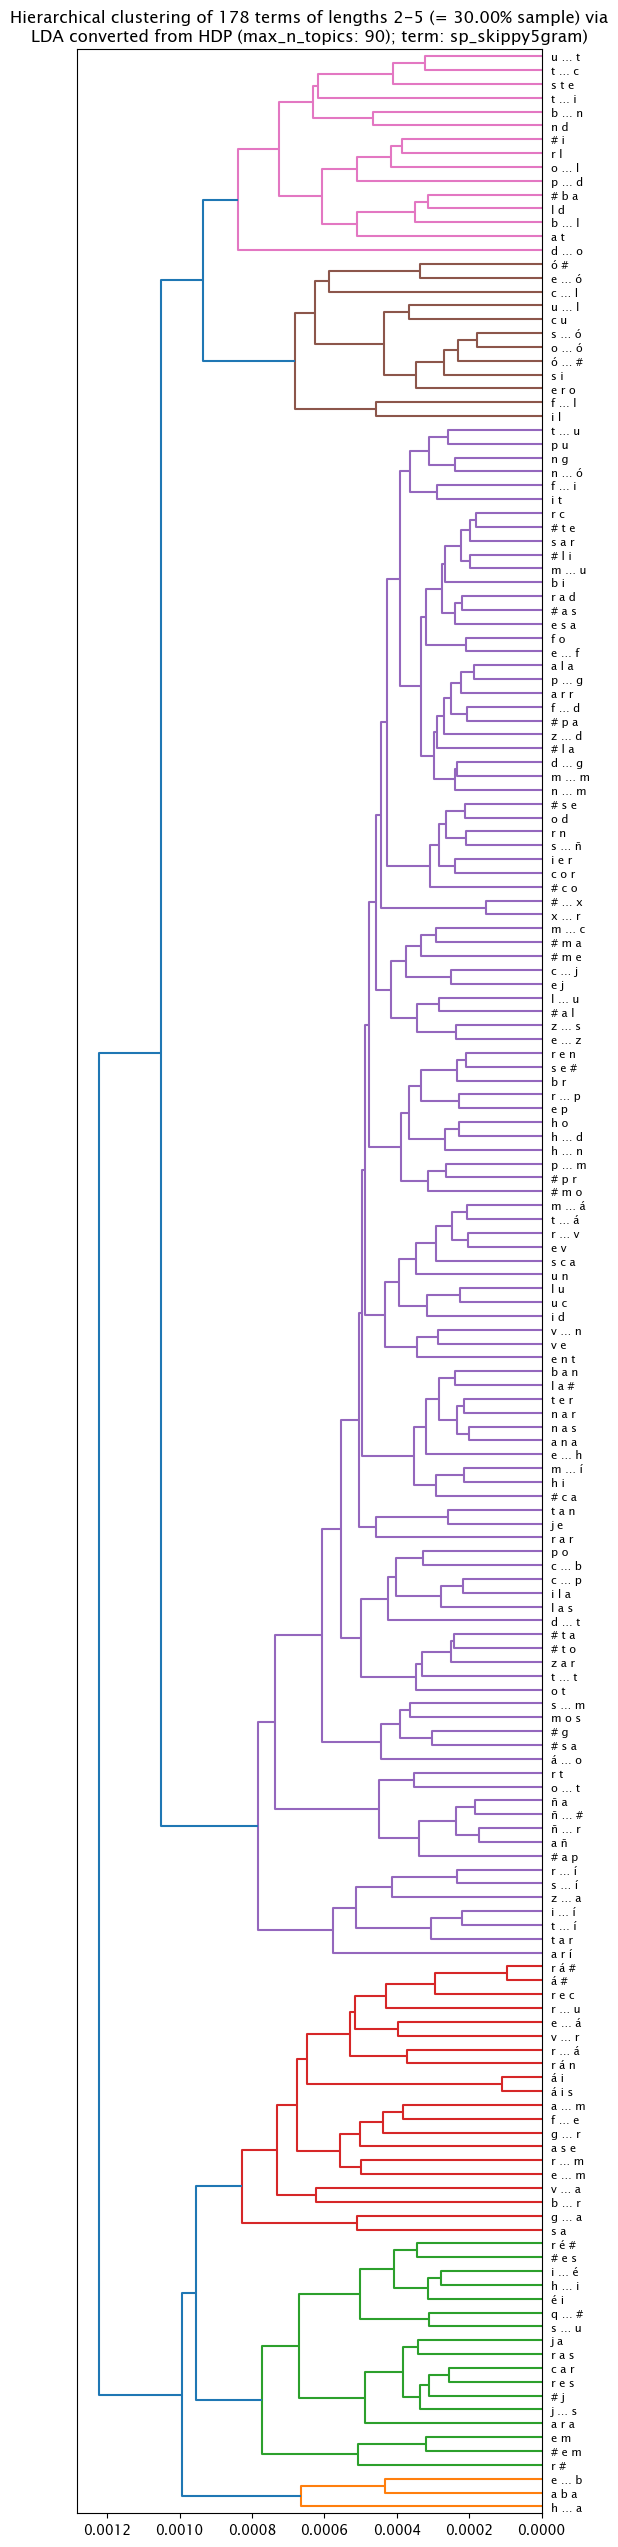

In [64]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp90, diction, term_type = term_type, n_topics = 90, lowest_density = 0.0012, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.3, check = False)